In [24]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import copy

import torch
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models
from torch import nn
from PIL import Image

In [362]:
imsize = 512
loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])

In [363]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    image = image[:, :, :imsize, :imsize]
    print(image.shape)
    return image

In [364]:
def imshow(image, unloader=transforms.ToPILImage()):
    image = image.clone().squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    plt.pause(0.01)

In [373]:
style = image_loader('style2.jpg')
content = image_loader('content.jpg')

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


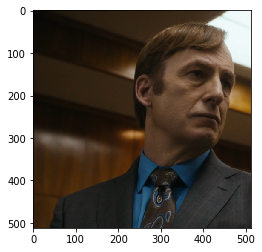

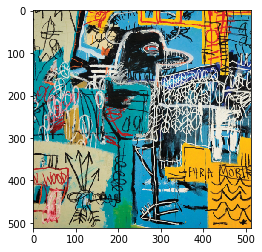

In [374]:
imshow(content)
imshow(style)

In [284]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = None
    
    def forward(self, x):
        self.loss = F.mse_loss(x, self.target)
        return x

In [113]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = self.gram(target.detach())
        self.loss = None
    
    def forward(self, x):
        predict = self.gram(x)
        self.loss = F.mse_loss(predict, self.target)
        return x
    
    def gram(self, x):
        Nx, Cx, Hx, Wx = x.size()
        x = x.view(Nx * Cx, Hx * Wx)
        return (x @ x.T) / (Nx * Cx * Hx * Wx)

In [114]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
    
    def forward(self, x):
        return (x - self.mean) / self.std

In [115]:
cnn = models.vgg19(pretrained=True).features.eval()
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

In [319]:
def layer_name(layer):
    name = str(type(layer))[25:]
    name = name[:-2]
    name = name.split('.')[-1]
    return name

def add_layer(model, layer, i):
    name = layer_name(layer)
    if isinstance(layer, nn.ReLU):
        layer.inplace = False
    model.add_module(name + ' '+ str([i + 1]), layer)
    return name

def add_loss(model, inp, loss_type, i):
    target = model(inp)
    loss = loss_type(target)
    add_layer(model, loss, i)
    return loss

def build_transfer_model(cnn, style, content, mean, std):
    cnn = copy.deepcopy(cnn)
    model = nn.Sequential(Normalization(mean, std))
    content_inds = [4]
    style_inds = [1, 2, 3, 4, 5]
    i = 0
    end = 0
    conv_numb = 0
    for layer in cnn.children():
        name = add_layer(model, layer, i)
        i += 1
        if isinstance(layer, nn.Conv2d):
            conv_numb += 1
            if conv_numb in style_inds:
                add_loss(model, style, StyleLoss, i)
                i += 1
                end = i
            
            if conv_numb in content_inds:
                add_loss(model, content, ContentLoss, i)
                i += 1
                end = i
    return model[:end + 1]

In [351]:
class TransferLoss(nn.Module):
    def __init__(self, model, style_weight, content_weight):
        super(TransferLoss, self).__init__()
        
        self.model = model
        self.loss = None
        self.sw = style_weight
        self.cw = content_weight
    
    def forward(self, image):
        self.loss = 0
        content_loss = 0
        style_loss = 0
        x = image
        for layer in self.model:
            x = layer(x)
            if isinstance(layer, ContentLoss):
                content_loss += layer.loss
            if isinstance(layer, StyleLoss):
                style_loss += layer.loss
        self.loss = self.sw * style_loss + self.cw * content_loss
        return x
    
    def backward(self):
        return self.loss.backward()
    
    def item(self):
        return self.loss.item()

In [375]:
def transfer_style(cnn, image, style, content, mean, std, steps=600, style_weight=1e6, content_weight=1):
    model = build_transfer_model(cnn, style, content, mean, std)
    optimizer = optim.LBFGS([image.requires_grad_()])
    loss = TransferLoss(model, style_weight, content_weight)
    i = 0
    
    while i < steps:
        def func():
            nonlocal i
            image.data.clamp_(0, 1)
            optimizer.zero_grad()
            loss(image)
            loss.backward()
            i += 1
            if i % 50 == 0:
                print(f'epoch {i}: {loss.item()}')
            return loss.item()
        optimizer.step(func)
        
    image.data.clamp_(0, 1)
    return image

In [376]:
image = torch.randn(content.data.size())

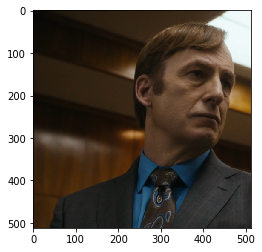

In [377]:
image = content.clone()
imshow(image)

In [378]:
output = transfer_style(cnn, image, style, content, mean, std)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


epoch 50: 1163.3826904296875
epoch 100: 256.8013916015625
epoch 150: 139.3538818359375
epoch 200: 104.10044860839844
epoch 250: 86.83204650878906
epoch 300: 77.36550903320312
epoch 350: 70.8614501953125
epoch 400: 66.65428161621094
epoch 450: 63.87886428833008
epoch 500: 61.8176383972168
epoch 550: 60.60002517700195
epoch 600: 59.39794158935547


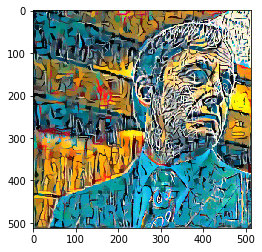

In [379]:
imshow(output)